In [31]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import time
from matplotlib import pyplot as plt

# 一、使用LeNet-5网络结构创建MNIST手写数字识别分类器

MNIST是一个非常有名的手写体数字识别数据集，训练样本：共60000个，其中55000个用于训练，另外5000个用于验证；测试样本：共10000个。MNIST数据集每张图片是单通道的，大小为28x28.

![](./images/mnist.jpg)

## 1.1 下载并加载数据，并做出一定的预先处理

由于MNIST数据集图片尺寸是28x28单通道的，而LeNet-5网络输入Input图片尺寸是32x32，因此使用transforms.Resize将输入图片尺寸调整为32x32。

In [51]:
pipline_train = transforms.Compose([
    #随机旋转图片
    transforms.RandomHorizontalFlip(),
    #将图片尺寸resize到32x32
    transforms.Resize((32,32)),
    #将图片转化为Tensor格式
    transforms.ToTensor(),
    #正则化(当模型出现过拟合的情况时，用来降低模型的复杂度)
    transforms.Normalize((0.1307,),(0.3081,))    
])
pipline_test = transforms.Compose([
    #将图片尺寸resize到32x32
    transforms.Resize((32,32)),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,),(0.3081,))
])
#下载数据集
train_set = datasets.MNIST(root="./data", train=True, download=True, transform=pipline_train)
test_set = datasets.MNIST(root="./data", train=False, download=True, transform=pipline_test)
#加载数据集
trainloader = torch.utils.data.DataLoader(train_set, batch_size=64, shuffle=True)
testloader = torch.utils.data.DataLoader(test_set, batch_size=32, shuffle=False)

**这里要解释一下Pytorch MNIST数据集标准化为什么是transforms.Normalize((0.1307,), (0.3081,))？**

**标准化（Normalization）**是神经网络对数据的一种经常性操作。标准化处理指的是：样本减去它的均值，再除以它的标准差，最终样本将呈现均值为0方差为1的数据分布。

神经网络模型偏爱标准化数据，原因是均值为0方差为1的数据在sigmoid、tanh经过激活函数后求导得到的导数很大，反之原始数据不仅分布不均（噪声大）而且数值通常都很大（本例中数值范围是0~255），激活函数后求导得到的导数则接近与0，这也被称为梯度消失。前文已经分析，神经网络是根据函数对权值求导的导数来调整权值，导数越大，调整幅度越大，越快逼近目标函数，反之，导数越小，调整幅度越小，所以说，数据的标准化有利于加快神经网络的训练。

除此之外，还需要保持train_set、val_set和test_set标准化系数的一致性。标准化系数就是计算要用到的均值和标准差，在本例中是((0.1307,), (0.3081,))，均值是0.1307，标准差是0.3081，这些系数都是数据集提供方计算好的数据。不同数据集就有不同的标准化系数，例如([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])就是ImageNet dataset的标准化系数（RGB三个通道对应三组系数），当需要将imagenet预训练的参数迁移到另一神经网络时，被迁移的神经网络就需要使用imagenet的系数，否则预训练不仅无法起到应有的作用甚至还会帮倒忙，

例如，我们想要用神经网络来识别夜空中的星星，因为黑色是夜空的主旋律，从像素上看黑色就是数据集的均值，标准化操作时，所有图像会减去均值（黑色），如此Imagenet预训练的神经网络很难识别出这些数据是夜空图像！

## 1.2 搭建LeNet-5神经网络结构，并定义前向传播的过程

In [33]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        #torch里的Conv2d不含激活函数参数，需要单独列出
        self.conv1 = nn.Conv2d(1, 6, 5) 
        self.relu = nn.ReLU()
        self.maxpool1 = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.maxpool2 = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(16*5*5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
 
    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.maxpool1(x)
        x = self.conv2(x)
        x = self.maxpool2(x)
        
        #这里相当于tf里的flatten，用于打平
        x = x.view(-1, 16*5*5)
        #https://www.zhihu.com/question/66782101/answer/579393790
        #nn 与 nn.functional的区别
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        output = F.log_softmax(x, dim=1)
        return output

## 1.3 将定义好的网络结构搭载到GPU/CPU，并定义优化器

In [34]:
#创建模型，部署gpu
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = LeNet().to(device)
#定义优化器
optimizer = optim.Adam(model.parameters(), lr=0.001)

## 1.4 定义训练过程

In [35]:
def train_runner(model, device, trainloader, optimizer, epoch):
    #训练模型, 启用 BatchNormalization 和 Dropout, 将BatchNormalization和Dropout置为True
    model.train()
    total = 0
    correct =0.0
    #enumerate迭代已加载的数据集,同时获取数据和数据下标
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        #把模型部署到device上
        inputs, labels = inputs.to(device), labels.to(device)
        #初始化梯度
        optimizer.zero_grad()
        #保存训练结果
        outputs = model(inputs)
        #计算损失和
        #多分类情况通常使用cross_entropy(交叉熵损失函数), 而对于二分类问题, 通常使用sigmod
        loss = F.cross_entropy(outputs, labels)
        #获取最大概率的预测结果
        #dim=1表示返回每一行的最大值对应的列下标
        predict = outputs.argmax(dim=1)
        #用于计算正确率
        total += labels.size(0)
        correct += (predict == labels).sum().item()
        #反向传播
        loss.backward()
        #更新参数
        optimizer.step()
        
        if i % 1000 == 0:
            #loss.item()表示当前loss的数值
            print("Train Epoch{} \t Loss: {:.6f}, accuracy: {:.6f}%".format(epoch, loss.item(), 100*(correct/total)))
            Loss.append(loss.item())
            Accuracy.append(correct/total)
    #这里返回最后一次数值
    return loss.item(), correct/total
    #return Loss, Accuracy

## 1.5 定义测试过程

In [36]:
def test_runner(model, device, testloader):
    #模型验证, 必须要写, 否则只要有输入数据, 即使不训练, 它也会改变权值
    #因为调用eval()将不启用 BatchNormalization 和 Dropout, BatchNormalization和Dropout置为False
    model.eval()
    #统计模型正确率, 设置初始值
    correct = 0.0
    test_loss = 0.0
    total = 0
    #torch.no_grad将不会计算梯度, 也不会进行反向传播
    with torch.no_grad():
        for data, label in testloader:
            data, label = data.to(device), label.to(device)
            output = model(data)
            test_loss += F.cross_entropy(output, label).item()
            predict = output.argmax(dim=1)
            #计算正确数量
            total += label.size(0)
            correct += (predict == label).sum().item()
        #计算损失值
        print("test_avarage_loss: {:.6f}, accuracy: {:.6f}%".format(test_loss/total, 100*(correct/total)))

## 1.6 运行

start_time 2021-12-29 16:23:06
Train Epoch1 	 Loss: 2.296196, accuracy: 6.250000%
test_avarage_loss: 0.004202, accuracy: 95.850000%
end_time:  2021-12-29 16:23:19 

start_time 2021-12-29 16:23:19
Train Epoch2 	 Loss: 0.111956, accuracy: 95.312500%
test_avarage_loss: 0.002767, accuracy: 97.270000%
end_time:  2021-12-29 16:23:32 

start_time 2021-12-29 16:23:32
Train Epoch3 	 Loss: 0.031504, accuracy: 100.000000%
test_avarage_loss: 0.002865, accuracy: 96.910000%
end_time:  2021-12-29 16:23:44 

start_time 2021-12-29 16:23:44
Train Epoch4 	 Loss: 0.175498, accuracy: 92.187500%
test_avarage_loss: 0.002199, accuracy: 97.600000%
end_time:  2021-12-29 16:23:57 

start_time 2021-12-29 16:23:57
Train Epoch5 	 Loss: 0.042042, accuracy: 98.437500%
test_avarage_loss: 0.002423, accuracy: 97.490000%
end_time:  2021-12-29 16:24:10 

Finished Training


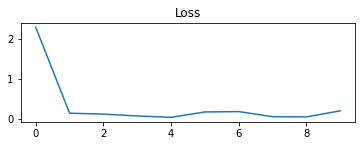

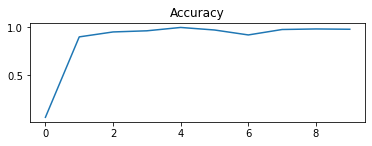

In [37]:
#调用
epoch = 5
Loss = []
Accuracy = []
for epoch in range(1, epoch+1):
    print("start_time",time.strftime('%Y-%m-%d %H:%M:%S',time.localtime(time.time())))
    loss, acc = train_runner(model, device, trainloader, optimizer, epoch)
    Loss.append(loss)
    Accuracy.append(acc)
    test_runner(model, device, testloader)
    print("end_time: ",time.strftime('%Y-%m-%d %H:%M:%S',time.localtime(time.time())),'\n')

print('Finished Training')
plt.subplot(2,1,1)
plt.plot(Loss)
plt.title('Loss')
plt.show()
plt.subplot(2,1,2)
plt.plot(Accuracy)
plt.title('Accuracy')
plt.show()

## 1.7 保存模型

In [38]:
print(model)
#torch.save(model, './models/model-mnist.pth') #保存模型,会出现警告
torch.save({'state_dict': model.state_dict()}, 'checkpoint.pth.tar')#不会出现警告

LeNet(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (relu): ReLU()
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


## 1.8 手写图片的测试

利用刚刚训练的模型进行手写图片的测试。

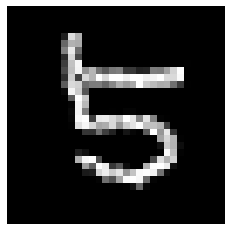

torch.Size([1, 32, 32])
概率： tensor([[9.4724e-10, 2.0288e-09, 1.0039e-05, 3.3863e-05, 3.5274e-09, 9.9995e-01,
         5.0075e-07, 1.1289e-06, 3.9708e-08, 4.6838e-08]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
预测类别： 5


In [39]:
import cv2

if __name__ == '__main__':
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    #加载模型方法一
    #model = torch.load('./models/model-mnist.pth') 
    #加载模型方法二，这个方法最终的准确率不高
    checkpoint = torch.load('checkpoint.pth.tar')
    model.load_state_dict(checkpoint['state_dict'])
    
    model = model.to(device)
    model.eval()    #把模型转为test模式
    
    #读取要预测的图片
    img = cv2.imread("./images/test_mnist.jpg")
    #最近邻插值方式修改图片尺寸
    img=cv2.resize(img,dsize=(32,32),interpolation=cv2.INTER_NEAREST)
    plt.imshow(img,cmap="gray") # 显示图片
    plt.axis('off') # 不显示坐标轴
    plt.show()
    
    # 导入图片，图片扩展后为[1，1，32，32]
    trans = transforms.Compose(
        [
            transforms.ToTensor(),
            transforms.Normalize((0.1307,), (0.3081,))
        ])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)#图片转为灰度图，因为mnist数据集都是灰度图
    img = trans(img)
    print(img.shape)
    img = img.to(device)
    img = img.unsqueeze(0)  #图片扩展多一维,因为输入到保存的模型中是4维的[batch_size,通道,长，宽]，而普通图片只有三维，[通道,长，宽]
    
    # 预测 
    #output = model(img)
    #predict = output.argmax(dim=1)
    #print(predict.item())
    
    
    
    # 预测 
    output = model(img)
    #https://blog.csdn.net/lz_peter/article/details/84574716 softmax多分类算法
    prob = F.softmax(output,dim=1) #prob是10个分类的概率
    print("概率：",prob)
    value, predicted = torch.max(output.data, 1)#返回每一行中最大值的那个元素，且返回其索引（返回最大元素在这一行的列索引）
    predict = output.argmax(dim=1)#直接返回行最大值的列索引
    print("预测类别：",predict.item())

# 二、使用LeNet-5网络结构创建CIFAR-10手写数字识别分类器

LeNet-5网络本是用来识别MNIST数据集的，下面我们来将LeNet-5应用到一个比较复杂的例子，识别CIFAR-10数据集。

CIFAR-10 是由 Hinton 的学生 Alex Krizhevsky 和 Ilya Sutskever 整理的一个用于识别普适物体的小型数据集。一共包含 10 个类别的 RGB 彩色图 片：飞机（ airlane ）、汽车（ automobile ）、鸟类（ bird ）、猫（ cat ）、鹿（ deer ）、狗（ dog ）、蛙类（ frog ）、马（ horse ）、船（ ship ）和卡车（ truck ）。图片的尺寸为 32×32 ，数据集中一共有 50000 张训练圄片和 10000 张测试图片。 CIFAR-10 的图片样例如图所示。

![](./images/cifar-10.png)

## 2.1 下载并加载数据，并做出一定的预先处理

In [42]:
pipline_train = transforms.Compose([
    #随机旋转图片
    transforms.RandomHorizontalFlip(),
    #将图片尺寸resize到32x32
    transforms.Resize((32,32)),
    #将图片转化为Tensor格式
    transforms.ToTensor(),
    #正则化(当模型出现过拟合的情况时，用来降低模型的复杂度)
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
pipline_test = transforms.Compose([
    #将图片尺寸resize到32x32
    transforms.Resize((32,32)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
#下载数据集
train_set = datasets.CIFAR10(root="./data/CIFAR10", train=True, download=True, transform=pipline_train)
test_set = datasets.CIFAR10(root="./data/CIFAR10", train=False, download=True, transform=pipline_test)
#加载数据集
trainloader = torch.utils.data.DataLoader(train_set, batch_size=64, shuffle=True)
testloader = torch.utils.data.DataLoader(test_set, batch_size=32, shuffle=False)
# 类别信息也是需要我们给定的
classes = ('plane', 'car', 'bird', 'cat','deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Using downloaded and verified file: ./data/CIFAR10\cifar-10-python.tar.gz
Extracting ./data/CIFAR10\cifar-10-python.tar.gz to ./data/CIFAR10
Files already downloaded and verified


## 2.2 搭建LeNet-5神经网络结构，并定义前向传播的过程

LeNet-5网络上文已经搭建过了，由于CIFAR10数据集图像是RGB三通道的，因此LeNet-5网络C1层卷积选择的滤波器需要3通道，网络其它结构跟上文都是一样的。

In [43]:
class LeNetRGB(nn.Module):
    def __init__(self):
        super(LeNetRGB, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)   # 3表示输入是3通道
        self.relu = nn.ReLU()
        self.maxpool1 = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.maxpool2 = nn.MaxPool2d(2, 2)
 
        self.fc1 = nn.Linear(16*5*5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
 
    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.maxpool1(x)
        x = self.conv2(x)
        x = self.maxpool2(x)
        x = x.view(-1, 16*5*5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        output = F.log_softmax(x, dim=1)
        return output

## 2.3 将定义好的网络结构搭载到GPU/CPU，并定义优化器

使用SGD（随机梯度下降）优化，学习率为0.001，动量为0.9

In [44]:
#创建模型，部署gpu
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = LeNetRGB().to(device)
#定义优化器
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
#optimizer = optim.Adam(model.parameters(), lr=0.001)

训练和测试函数的定义跟LeNet-5章节定义的一样。

## 2.4 定义训练过程

In [45]:
def train_runner(model, device, trainloader, optimizer, epoch):
    #训练模型, 启用 BatchNormalization 和 Dropout, 将BatchNormalization和Dropout置为True
    model.train()
    total = 0
    correct =0.0
    
    #enumerate迭代已加载的数据集,同时获取数据和数据下标
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        #把模型部署到device上
        inputs, labels = inputs.to(device), labels.to(device)
        #初始化梯度
        optimizer.zero_grad()
        #保存训练结果
        outputs = model(inputs)
        #计算损失和
        #多分类情况通常使用cross_entropy(交叉熵损失函数), 而对于二分类问题, 通常使用sigmod
        loss = F.cross_entropy(outputs, labels)
        #获取最大概率的预测结果
        #dim=1表示返回每一行的最大值对应的列下标
        predict = outputs.argmax(dim=1)
        total += labels.size(0)
        correct += (predict == labels).sum().item()
        #反向传播
        loss.backward()
        #更新参数
        optimizer.step()
        if i % 1000 == 0:
            #loss.item()表示当前loss的数值
            print("Train Epoch{} \t Loss: {:.6f}, accuracy: {:.6f}%".format(epoch, loss.item(), 100*(correct/total)))
            Loss.append(loss.item())
            Accuracy.append(correct/total)
    return loss.item(), correct/total

## 2.5 定义测试过程

In [46]:
def test_runner(model, device, testloader):
    #模型验证, 必须要写, 否则只要有输入数据, 即使不训练, 它也会改变权值
    #因为调用eval()将不启用 BatchNormalization 和 Dropout, BatchNormalization和Dropout置为False
    model.eval()
    #统计模型正确率, 设置初始值
    correct = 0.0
    test_loss = 0.0
    total = 0
    #torch.no_grad将不会计算梯度, 也不会进行反向传播
    with torch.no_grad():
        for data, label in testloader:
            data, label = data.to(device), label.to(device)
            output = model(data)
            test_loss += F.cross_entropy(output, label).item()
            predict = output.argmax(dim=1)
            #计算正确数量
            total += label.size(0)
            correct += (predict == label).sum().item()
        #计算损失值
        print("test_avarage_loss: {:.6f}, accuracy: {:.6f}%".format(test_loss/total, 100*(correct/total)))

## 2.6 运行

start_time 2021-12-29 16:48:12
Train Epoch1 	 Loss: 2.306606, accuracy: 12.500000%
test_avarage_loss: 0.045070, accuracy: 47.340000%
end_time:  2021-12-29 16:48:24 

start_time 2021-12-29 16:48:24
Train Epoch2 	 Loss: 1.328040, accuracy: 51.562500%
test_avarage_loss: 0.040210, accuracy: 53.600000%
end_time:  2021-12-29 16:48:35 

start_time 2021-12-29 16:48:35
Train Epoch3 	 Loss: 1.298900, accuracy: 50.000000%
test_avarage_loss: 0.038545, accuracy: 56.000000%
end_time:  2021-12-29 16:48:47 

start_time 2021-12-29 16:48:47
Train Epoch4 	 Loss: 1.304604, accuracy: 59.375000%
test_avarage_loss: 0.035276, accuracy: 60.360000%
end_time:  2021-12-29 16:48:59 

start_time 2021-12-29 16:48:59
Train Epoch5 	 Loss: 1.207372, accuracy: 64.062500%
test_avarage_loss: 0.033961, accuracy: 62.020000%
end_time:  2021-12-29 16:49:10 

start_time 2021-12-29 16:49:10
Train Epoch6 	 Loss: 0.957357, accuracy: 64.062500%
test_avarage_loss: 0.034754, accuracy: 61.410000%
end_time:  2021-12-29 16:49:22 

star

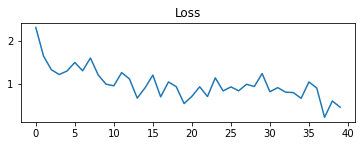

0it [13:38, ?it/s]
 50%|█████     | 85557248/170498071 [13:37<13:31, 104622.26it/s]


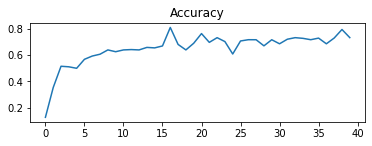

In [47]:
#调用
epoch = 20
Loss = []
Accuracy = []
for epoch in range(1, epoch+1):
    print("start_time",time.strftime('%Y-%m-%d %H:%M:%S',time.localtime(time.time())))
    loss, acc = train_runner(model, device, trainloader, optimizer, epoch)
    Loss.append(loss)
    Accuracy.append(acc)
    test_runner(model, device, testloader)
    print("end_time: ",time.strftime('%Y-%m-%d %H:%M:%S',time.localtime(time.time())),'\n')

print('Finished Training')
plt.subplot(2,1,1)
plt.plot(Loss)
plt.title('Loss')
plt.show()
plt.subplot(2,1,2)
plt.plot(Accuracy)
plt.title('Accuracy')
plt.show()

## 2.7 保存模型

In [48]:
print(model)
#torch.save(model, './models/model-cifar10.pth') #保存模型
torch.save({'state_dict': model.state_dict()}, 'checkpoint.pth.tar')
#torch.save(model.state_dict(), './models/net_parms.pkl')#只保存网络中的参数（速度快，占内存少）

LeNetRGB(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (relu): ReLU()
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


## 2.8 模型测试

利用刚刚训练的模型进行CIFAR10类型图片的测试。

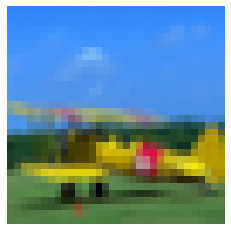

概率： tensor([[7.6907e-01, 3.3997e-03, 4.8003e-03, 4.2978e-05, 1.2168e-02, 6.8751e-06,
         3.2019e-06, 1.6024e-04, 1.2705e-01, 8.3300e-02]],
       grad_fn=<SoftmaxBackward>)
5
预测类别： plane


In [17]:
from PIL import Image
import numpy as np

if __name__ == '__main__':
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = torch.load('./models/model-cifar10.pth') #加载模型
    model = model.to(device)
    model.eval()    #把模型转为test模式
    
    #读取要预测的图片
    # 读取要预测的图片
    img = Image.open("./images/test_cifar10.png").convert('RGB') # 读取图像
    #img.show()
    plt.imshow(img) # 显示图片
    plt.axis('off') # 不显示坐标轴
    plt.show()
    
    # 导入图片，图片扩展后为[1，1，32，32]
    trans = transforms.Compose(
        [
            #将图片尺寸resize到32x32
            transforms.Resize((32,32)),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ])
    img = trans(img)
    img = img.to(device)
    img = img.unsqueeze(0)  #图片扩展多一维,因为输入到保存的模型中是4维的[batch_size,通道,长，宽]，而普通图片只有三维，[通道,长，宽]
    
    # 预测 
    classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
    output = model(img)
    prob = F.softmax(output,dim=1) #prob是10个分类的概率
    print("概率：",prob)
    print(predict.item())
    value, predicted = torch.max(output.data, 1)
    predict = output.argmax(dim=1)
    pred_class = classes[predicted.item()]
    print("预测类别：",pred_class)

# 三、用LeNet-5训练自己的数据

下面使用LeNet-5网络来训练本地的数据并进行测试。数据集是本地的LED数字0-9，尺寸为28x28单通道，跟MNIST数据集类似。训练集0-9各95张，测试集0~9各40张。图片样例如图所示：

![](./images/lednum.png)

## 3.1 数据预处理 

### 制作图片数据的索引

对于训练集和测试集，要分别制作对应的图片数据索引，即train.txt和test.txt两个文件，每个txt中包含每个图片的目录和对应类别class。示意图如下：

![](./images/index.png)

制作图片数据索引的python脚本程序如下：

In [3]:
import os

train_txt_path = os.path.join("data", "LEDNUM", "train.txt")
train_dir = os.path.join("data", "LEDNUM", "train_data")
valid_txt_path = os.path.join("data", "LEDNUM", "test.txt")
valid_dir = os.path.join("data", "LEDNUM", "test_data")

# def my_mkdir(my_dir):
#     if not os.path.isdir(my_dir):
#         os.makedirs(my_dir)

# my_mkdir(train_txt_path)
# my_mkdir(train_dir)
# my_mkdir(valid_txt_path)
# my_mkdir(valid_dir)

def gen_txt(txt_path, img_dir):
    f = open(txt_path, 'w')
    
    for root, s_dirs, _ in os.walk(img_dir, topdown=True):  # 获取 train文件下各文件夹名称
        for sub_dir in s_dirs:
            i_dir = os.path.join(root, sub_dir)             # 获取各类的文件夹 绝对路径
            img_list = os.listdir(i_dir)                    # 获取类别文件夹下所有png图片的路径
            for i in range(len(img_list)):
                if not img_list[i].endswith('jpg'):         # 若不是png文件，跳过
                    continue
                label = img_list[i].split('_')[0]
                img_path = os.path.join(i_dir, img_list[i])
                line = img_path + ' ' + label + '\n'
                f.write(line)
    f.close()

if __name__ == '__main__':
    gen_txt(train_txt_path, train_dir)
    gen_txt(valid_txt_path, valid_dir)

运行脚本之后就在./data/LEDNUM/目录下生成train.txt和test.txt两个索引文件。

### 构建Dataset子类

pytorch 加载自己的数据集，需要写一个继承自torch.utils.data中Dataset类，并修改其中的__init__方法、__getitem__方法、__len__方法。默认加载的都是图片，__init__的目的是得到一个包含数据和标签的list，每个元素能找到图片位置和其对应标签。然后用__getitem__方法得到每个元素的图像像素矩阵和标签，返回img和label。 

In [19]:
from PIL import Image
from torch.utils.data import Dataset

class MyDataset(Dataset):
    def __init__(self, txt_path, transform = None, target_transform = None):
        fh = open(txt_path, 'r')
        imgs = []
        for line in fh:
            line = line.rstrip()
            words = line.split()
            imgs.append((words[0], int(words[1])))
            self.imgs = imgs 
            self.transform = transform
            self.target_transform = target_transform
    def __getitem__(self, index):
        fn, label = self.imgs[index]
        #img = Image.open(fn).convert('RGB') 
        img = Image.open(fn)
        if self.transform is not None:
            img = self.transform(img) 
        return img, label
    def __len__(self):
        return len(self.imgs)

getitem是核心函数。self.imgs是一个list，self.imgs[index]是一个str，包含图片路径，图片标签，这些信息是从上面生成的txt文件中读取；利用Image.open对图片进行读取，注意这里的img是单通道还是三通道的；self.transform(img)对图片进行处理，这个transform里边可以实现减均值、除标准差、随机裁剪、旋转、翻转、放射变换等操作。

当Mydataset构建好，剩下的操作就交给DataLoder，在DataLoder中，会触发Mydataset中的getiterm函数读取一张图片的数据和标签，并拼接成一个batch返回，作为模型真正的输入。

In [20]:
pipline_train = transforms.Compose([
    #随机旋转图片
    transforms.RandomHorizontalFlip(),
    #将图片尺寸resize到32x32
    transforms.Resize((32,32)),
    #将图片转化为Tensor格式
    transforms.ToTensor(),
    #正则化(当模型出现过拟合的情况时，用来降低模型的复杂度)
    transforms.Normalize((0.1307,),(0.3081,))    
])
pipline_test = transforms.Compose([
    #将图片尺寸resize到32x32
    transforms.Resize((32,32)),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,),(0.3081,))
])
train_data = MyDataset('./data/LEDNUM/train.txt', transform=pipline_train)
test_data = MyDataset('./data/LEDNUM/test.txt', transform=pipline_test)

#train_data 和test_data包含多有的训练与测试数据，调用DataLoader批量加载
trainloader = torch.utils.data.DataLoader(dataset=train_data, batch_size=8, shuffle=True)
testloader = torch.utils.data.DataLoader(dataset=test_data, batch_size=4, shuffle=False)

## 3.2 搭建LeNet-5神经网络结构

In [21]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5) 
        self.relu = nn.ReLU()
        self.maxpool1 = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.maxpool2 = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(16*5*5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
 
    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.maxpool1(x)
        x = self.conv2(x)
        x = self.maxpool2(x)
        x = x.view(-1, 16*5*5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        output = F.log_softmax(x, dim=1)
        return output

## 3.3 将定义好的网络结构搭载到GPU/CPU，并定义优化器

In [22]:
#创建模型，部署gpu
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = LeNet().to(device)
#定义优化器
optimizer = optim.Adam(model.parameters(), lr=0.001)

### 3.4 定义训练函数

In [23]:
def train_runner(model, device, trainloader, optimizer, epoch):
    #训练模型, 启用 BatchNormalization 和 Dropout, 将BatchNormalization和Dropout置为True
    model.train()
    total = 0
    correct =0.0
    
    #enumerate迭代已加载的数据集,同时获取数据和数据下标
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        #把模型部署到device上
        inputs, labels = inputs.to(device), labels.to(device)
        #初始化梯度
        optimizer.zero_grad()
        #保存训练结果
        outputs = model(inputs)
        #计算损失和
        #多分类情况通常使用cross_entropy(交叉熵损失函数), 而对于二分类问题, 通常使用sigmod
        loss = F.cross_entropy(outputs, labels)
        #获取最大概率的预测结果
        #dim=1表示返回每一行的最大值对应的列下标
        predict = outputs.argmax(dim=1)
        total += labels.size(0)
        correct += (predict == labels).sum().item()
        #反向传播
        loss.backward()
        #更新参数
        optimizer.step()
        if i % 100 == 0:
            #loss.item()表示当前loss的数值
            print("Train Epoch{} \t Loss: {:.6f}, accuracy: {:.6f}%".format(epoch, loss.item(), 100*(correct/total)))
            Loss.append(loss.item())
            Accuracy.append(correct/total)
    return loss.item(), correct/total

## 3.5 定义测试函数

In [24]:
def test_runner(model, device, testloader):
    #模型验证, 必须要写, 否则只要有输入数据, 即使不训练, 它也会改变权值
    #因为调用eval()将不启用 BatchNormalization 和 Dropout, BatchNormalization和Dropout置为False
    model.eval()
    #统计模型正确率, 设置初始值
    correct = 0.0
    test_loss = 0.0
    total = 0
    #torch.no_grad将不会计算梯度, 也不会进行反向传播
    with torch.no_grad():
        for data, label in testloader:
            data, label = data.to(device), label.to(device)
            output = model(data)
            test_loss += F.cross_entropy(output, label).item()
            predict = output.argmax(dim=1)
            #计算正确数量
            total += label.size(0)
            correct += (predict == label).sum().item()
        #计算损失值
        print("test_avarage_loss: {:.6f}, accuracy: {:.6f}%".format(test_loss/total, 100*(correct/total)))

## 3.6 运行

start_time 2021-11-27 22:29:46
Train Epoch1 	 Loss: 2.381566, accuracy: 12.500000%
Train Epoch1 	 Loss: 0.016064, accuracy: 75.123762%
test_avarage_loss: 0.013390, accuracy: 98.250000%
end_time:  2021-11-27 22:29:47 

start_time 2021-11-27 22:29:47
Train Epoch2 	 Loss: 0.005825, accuracy: 100.000000%
Train Epoch2 	 Loss: 0.001058, accuracy: 99.752475%
test_avarage_loss: 0.026550, accuracy: 96.250000%
end_time:  2021-11-27 22:29:48 

start_time 2021-11-27 22:29:48
Train Epoch3 	 Loss: 0.149143, accuracy: 87.500000%
Train Epoch3 	 Loss: 0.001346, accuracy: 99.628713%
test_avarage_loss: 0.008281, accuracy: 98.000000%
end_time:  2021-11-27 22:29:50 

start_time 2021-11-27 22:29:50
Train Epoch4 	 Loss: 0.002901, accuracy: 100.000000%
Train Epoch4 	 Loss: 0.001207, accuracy: 99.504950%
test_avarage_loss: 0.000260, accuracy: 100.000000%
end_time:  2021-11-27 22:29:51 

start_time 2021-11-27 22:29:51
Train Epoch5 	 Loss: 0.000148, accuracy: 100.000000%
Train Epoch5 	 Loss: 0.005780, accuracy: 

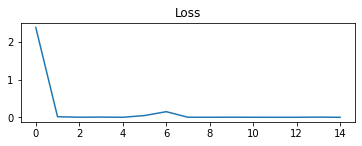

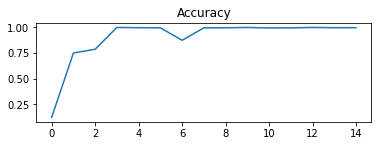

In [25]:
#调用
epoch = 5
Loss = []
Accuracy = []
for epoch in range(1, epoch+1):
    print("start_time",time.strftime('%Y-%m-%d %H:%M:%S',time.localtime(time.time())))
    loss, acc = train_runner(model, device, trainloader, optimizer, epoch)
    Loss.append(loss)
    Accuracy.append(acc)
    test_runner(model, device, testloader)
    print("end_time: ",time.strftime('%Y-%m-%d %H:%M:%S',time.localtime(time.time())),'\n')

print('Finished Training')
plt.subplot(2,1,1)
plt.plot(Loss)
plt.title('Loss')
plt.show()
plt.subplot(2,1,2)
plt.plot(Accuracy)
plt.title('Accuracy')
plt.show()

## 3.7 模型保存

In [26]:
model
torch.save(model, './models/model-mine.pth') #保存模型

## 3.8 模型测试

下面使用上面训练的模型对一张LED图片进行测试。

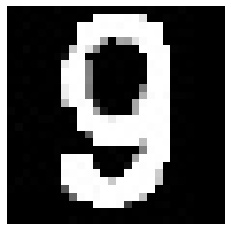

概率： tensor([[7.2506e-11, 7.0065e-18, 7.1749e-06, 7.4855e-13, 7.3532e-08, 8.5405e-17,
         2.5753e-15, 9.7887e-10, 2.7855e-05, 9.9996e-01]],
       grad_fn=<SoftmaxBackward>)
预测类别： 9


In [27]:
from PIL import Image
import numpy as np

if __name__ == '__main__':
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = torch.load('./models/model-mine.pth') #加载模型
    model = model.to(device)
    model.eval()    #把模型转为test模式
    
    #读取要预测的图片
    # 读取要预测的图片
    img = Image.open("./images/test_led.jpg") # 读取图像
    #img.show()
    plt.imshow(img,cmap="gray") # 显示图片
    plt.axis('off') # 不显示坐标轴
    plt.show()
    
    # 导入图片，图片扩展后为[1，1，32，32]
    trans = transforms.Compose(
        [
            #将图片尺寸resize到32x32
            transforms.Resize((32,32)),
            transforms.ToTensor(),
            transforms.Normalize((0.1307,), (0.3081,))
        ])
    img = trans(img)
    img = img.to(device)
    img = img.unsqueeze(0)  #图片扩展多一维,因为输入到保存的模型中是4维的[batch_size,通道,长，宽]，而普通图片只有三维，[通道,长，宽]
    
    # 预测 
    output = model(img)
    prob = F.softmax(output,dim=1) #prob是10个分类的概率
    print("概率：",prob)
    value, predicted = torch.max(output.data, 1)
    predict = output.argmax(dim=1)
    print("预测类别：",predict.item())